In [1]:
# Import pipeline
from transcription_pipeline import nuclear_pipeline
from transcription_pipeline import preprocessing_pipeline

from transcription_pipeline import spot_pipeline
from transcription_pipeline import fullEmbryo_pipeline

# Importing libraries
import matplotlib.pyplot as plt
import numpy as np
from transcription_pipeline.spot_analysis import compile_data
from transcription_pipeline.utils import plottable

from scipy.signal import medfilt
from skimage.restoration import denoise_tv_chambolle

import numpy as np
from scipy.optimize import least_squares
from scipy.stats import chi2
import pandas as pd
import emcee

`JAVA_HOME` environment variable set to /mnt/Data1/Nick/miniforge3/envs/transcription_pipeline


## Import Dataset

In [2]:
RBSPWM_datasets = [
    "test_data/2024-02-26/Halo-RBSPWM_embryo01",
    "test_data/2024-02-26/Halo-RBSPWM_embryo02",
    "test_data/2024-05-07/Halo552-RBSPWM_embryo01",
    "test_data/2024-05-07/Halo552-RBSPWM_embryo02",
    "test_data/2024-05-09/Halo552-RBSPWM_embryo01",
    "../../Josh/transcription_pipeline-main/test_data/2024-05-09/Halo552-RBSPWM_embryo01/"
]

RBSVar2_datasets = [
    "test_data/2024-07-23/Halo673_RBSVar2_embryo01",
    "test_data/2024-07-25/Halo673_RBSVar2_embryo01"
]

test_dataset_name = RBSVar2_datasets[1]

### Import from Scratch

#### Import MS2 Dataset

In [ ]:
## Import from scratch
dataset = preprocessing_pipeline.DataImport(
    name_folder=test_dataset_name,
    trim_series=True,
    working_storage_mode='zarr',
    # import_previous=True, 
)
dataset.save();

#### Import FullEmbryo Dataset

In [3]:
FullEmbryo_dataset = preprocessing_pipeline.FullEmbryoImport(
    name_folder=test_dataset_name,
    #import_previous=True
)
FullEmbryo_dataset.save()

### Load from Zarr

#### Load MS2 Dataset

In [4]:
## Load from zarr
dataset = preprocessing_pipeline.DataImport(
    name_folder=test_dataset_name,
    trim_series=True,
    # working_storage_mode='zarr',
    import_previous=True, 
)

#### Load FullEmbryo Dataset

In [ ]:
# FullEmbryo_dataset = preprocessing_pipeline.FullEmbryoImport(
#     name_folder=test_dataset_name,
#     import_previous=True
# )
# Not working currently, but reported to Yovan where it only reads in the last channel


## Starting a DASK Client for parallel processing

In [ ]:
from dask.distributed import LocalCluster, Client

try:
    cluster = LocalCluster(
        host="localhost",
        scheduler_port=37763,
        threads_per_worker=1,
        n_workers=14,
        memory_limit="6GB",
    )
    
    client = Client(cluster)
except:
    print("Cluster already running")
    client = Client('localhost:37763')

print(client)

In [ ]:
client.restart()

In [ ]:
client

## Nuclear Tracking

In [ ]:
nuclear_tracking = nuclear_pipeline.Nuclear(
    data=dataset.channels_full_dataset[0],
    global_metadata=dataset.export_global_metadata[0],
    frame_metadata=dataset.export_frame_metadata[0],
    series_splits=dataset.series_splits,
    series_shifts=dataset.series_shifts,
    search_range_um=1.5,
    stitch=False,
    stitch_max_distance=4,
    stitch_max_frame_distance=2,
    client=client,
    keep_futures=False,
)

nuclear_tracking.track_nuclei(
        working_memory_mode="zarr",
        working_memory_folder=test_dataset_name,
        trackpy_log_path="".join([test_dataset_name, "trackpy_log"]),
    )
    # Saves tracked nuclear mask as a zarr, and pickles dataframes with segmentation and
    # tracking information.
nuclear_tracking.save_results(
        name_folder=test_dataset_name, save_array_as=None
    )

In [ ]:
# Load nuclear tracking results
nuclear_tracking = nuclear_pipeline.Nuclear()
nuclear_tracking.read_results(name_folder=test_dataset_name)

## Spot Tracking

In [ ]:
%%time

spot_tracking = spot_pipeline.Spot(
    data=dataset.channels_full_dataset[1],
    global_metadata=dataset.export_global_metadata[1],
    frame_metadata=dataset.export_frame_metadata[1],
    labels=None,#nuclear_tracking.reordered_labels,
    expand_distance=3,
    search_range_um=4.2,
    retrack_search_range_um=4.5,
    threshold_factor=1.3,
    memory=3,
    retrack_after_filter=False,
    stitch=True,
    min_track_length=0,
    series_splits=dataset.series_splits,
    series_shifts=dataset.series_shifts,
    keep_bandpass=False,
    keep_futures=False,
    keep_spot_labels=False,
    evaluate=True,
    retrack_by_intensity=True,
    client=client,
)

spot_tracking.extract_spot_traces(
    working_memory_folder=test_dataset_name, 
    stitch=True,
    retrack_after_filter=True,
    trackpy_log_path = test_dataset_name+'/trackpy_log'
)

# Saves tracked spot mask as a zarr, and pickles dataframes with spot fitting and
# quantification information.
spot_tracking.save_results(name_folder=test_dataset_name, save_array_as='None')

## Make Compiled Dataframe

In [ ]:
# Load spot tracking results
track_spots = spot_pipeline.Spot()
track_spots.read_results(name_folder=test_dataset_name)

# Load spot tracking dataframe
spot_df = track_spots.spot_dataframe

# Remove spots that were not detected
detected_spots = spot_df[spot_df["particle"] != 0]

# Compile traces
compiled_dataframe = compile_data.compile_traces(
    detected_spots,
    compile_columns_spot=[
        "frame",
        "t_s",
        "intensity_from_neighborhood",
        "intensity_std_error_from_neighborhood",
        "x",
        "y"
    ],
    nuclear_tracking_dataframe=None,
)
compiled_dataframe.head()

## Full Embryo Analysis

In [ ]:
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(FullEmbryo_dataset.channels_full_dataset_surf[0][0, :, :], cmap='gray')
plt.title('Full Embryo Surf')

plt.subplot(1, 2, 2)
plt.imshow(FullEmbryo_dataset.channels_full_dataset_mid[0][0, :, :], cmap='gray')
plt.title('Full Embryo Mid')

plt.tight_layout()
plt.show()

In [5]:
fullEmbryo = fullEmbryo_pipeline.FullEmbryo(FullEmbryo_dataset, dataset, his_channel=0)

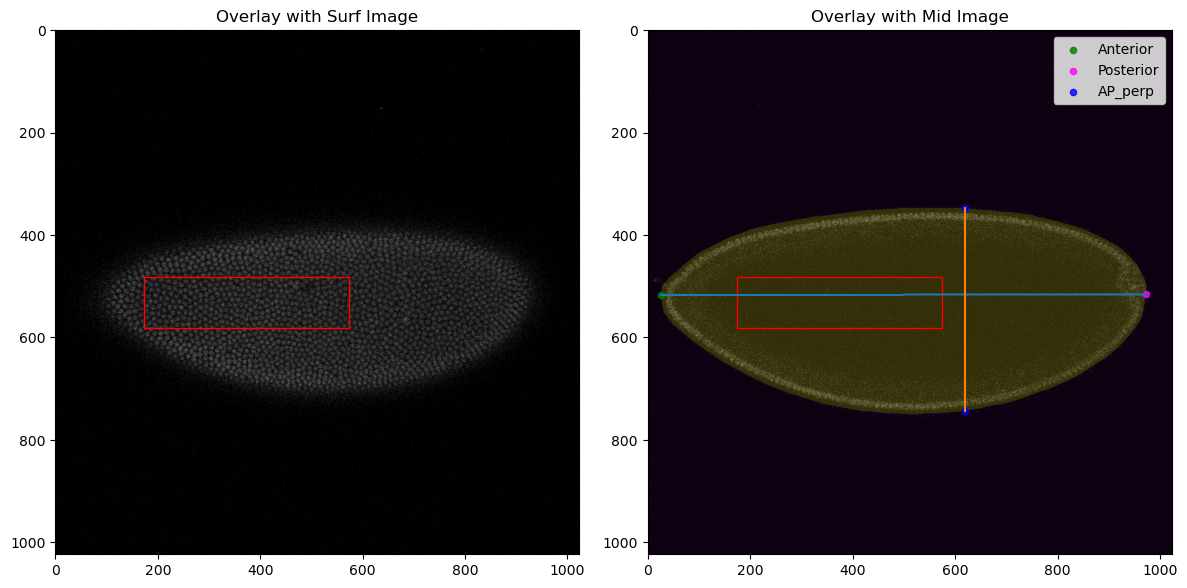

In [6]:
fullEmbryo.find_ap_axis(make_plots=True)

# Plot Traces

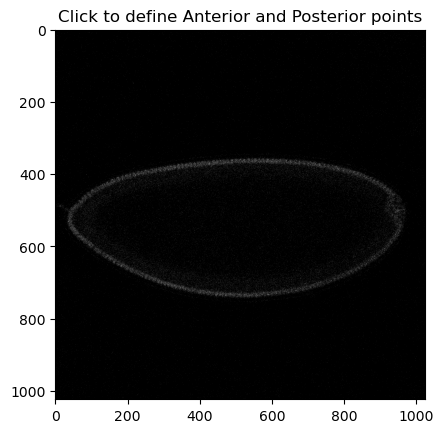

Please select exactly two points: one for Anterior and one for Posterior.


In [7]:
fullEmbryo.define_ap_points()

In [ ]:
# Restrict to longer traces
min_frames = 60
traces_compiled_dataframe = compiled_dataframe[
    compiled_dataframe["frame"].apply(lambda x: x.size) > min_frames
]
plt.close()

In [ ]:
plt.close()

In [ ]:
# %matplotlib widget
# This is taken from https://stackoverflow.com/questions/18390461/scroll-backwards-and-forwards-through-matplotlib-plots
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt


from scipy.signal import medfilt
from skimage.restoration import denoise_tv_chambolle

traces = plottable.generate_trace_plot_list(traces_compiled_dataframe)
#median_filtered_traces = [medfilt(trace[1], kernel_size=15) for trace in traces]

tv_denoised_traces = [
    denoise_tv_chambolle(trace[1], weight=1080, max_num_iter=500) for trace in traces
]
# potts_steps_traces = [
#     potts_l1.l1_potts_step_detection(trace[1], gamma=-5e3, weights=(1 / trace[2] ** 2))
#     for trace in traces
# ]


# plt.close()
# plt.plot(traces[curr_pos][0], traces[curr_pos][1], label="Original")otts_l1.l1_potts_step_detection(trace[1], gamma=-5e3, weights=(1 / trace[2] ** 2))
#     for trace in traces
# ]

curr_pos = 0


def key_event(e):
    global curr_pos

    if e.key == "right":
        curr_pos = curr_pos + 1
    elif e.key == "left":
        curr_pos = curr_pos - 1
    else:
        return
    curr_pos = curr_pos % len(traces)

    ax.cla()
    ax.errorbar(
        traces[curr_pos][0],
        traces[curr_pos][1],
        yerr=traces[curr_pos][2],
        fmt=".",
        elinewidth=1,
    )
    # ax.plot(traces[curr_pos][0], median_filtered_traces[curr_pos], color="k")
    ax.plot(traces[curr_pos][0], tv_denoised_traces[curr_pos], color="k", label="TV")
    # ax.step(
    #     traces[curr_pos][0],
    #     potts_steps_traces[curr_pos],
    #     where="mid",
    #     color="red",
    #     label="Potts L1",
    # )
    ax.set_xlabel("time (s)")
    ax.set_ylabel("Spot intensity (AU)")

    particle = traces[curr_pos][3]
    mean_x = (
        compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "x"]
        .values[0]
        .mean()
    )
    initial_frame = (
    compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "frame"]
    .values[0][0]
    )
    ax.set_title(f"Particle {particle}, x = {mean_x}, Initial frame {initial_frame}")
    ax.legend()
    fig.canvas.draw()


fig = plt.figure()
fig.canvas.mpl_connect("key_press_event", key_event)

ax = fig.add_subplot(111)
ax.errorbar(
    traces[curr_pos][0],
    traces[curr_pos][1],
    yerr=traces[curr_pos][2],
    fmt=".",
    elinewidth=1,
)
# ax.plot(traces[curr_pos][0], median_filtered_traces[curr_pos], color="k")
ax.plot(traces[curr_pos][0], tv_denoised_traces[curr_pos], color="k", label="TV")
# ax.step(
#     traces[curr_pos][0],
#     potts_steps_traces[curr_pos],
#     where="mid",
#     color="red",
#     label="Potts L1",
# )
ax.set_xlabel("time (s)")
ax.set_ylabel("Spot intensity (AU)")

particle = traces[curr_pos][3]
mean_x = (
    compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "x"]
    .values[0]
    .mean()
)
initial_frame = (
    compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "frame"]
    .values[0][0]
)
ax.set_title(f"Particle {particle}, x = {mean_x}, Initial frame {initial_frame}")
ax.legend()

plt.show()

## Define Fit Functions

In [ ]:
import numpy as np
from scipy.optimize import least_squares
from scipy.stats import chi2
import pandas as pd
import emcee

# Version with normalization and regularization
def make_half_cycle(basal, t_on, t_dwell, rate, t_interp):
    half_cycle = np.zeros_like(t_interp)
    half_cycle[t_interp < t_on] = basal
    half_cycle[(t_interp >= t_on) & (t_interp < t_on + t_dwell)] = basal + rate * (t_interp[(t_interp >= t_on) & (t_interp < t_on + t_dwell)] - t_on)
    half_cycle[t_interp >= t_on + t_dwell] = basal + rate * t_dwell
    return half_cycle

def fit_func(params, MS2, timepoints, t_interp):
    return np.interp(timepoints, t_interp, make_half_cycle(*params, t_interp)) - MS2

def initial_guess(MS2, timepoints):
    # Initial guess for the parameters
    basal0 = MS2[0]
    t_on0 = timepoints[0]
    t_dwell0 = (2/3)*(timepoints[-1]-timepoints[0])
    rate0 = 1
    # print(np.max(mean_dy_dx))
    return [basal0, t_on0, t_dwell0, rate0]


def fit_half_cycle(MS2, timepoints, t_interp, std_errors, max_nfev=3000):
    # Initial guess
    x0 = initial_guess(MS2, timepoints)
    
    # Parameter bounds
    lb = [np.min(MS2), 0, 0, 0]  # Ensure t_dwell is non-negative
    ub = [np.max(MS2), np.max(timepoints), np.max(timepoints), 1e7]

    # Scaling factors to normalize parameters
    scale_factors = np.array([np.max(MS2), np.max(timepoints), np.max(timepoints), 100])

    # Scaled bounds
    lb_scaled = np.array(lb) / scale_factors
    ub_scaled = np.array(ub) / scale_factors
    x0_scaled = np.array(x0) / scale_factors

    # Scaled fit function
    def fit_func_scaled(params, MS2, timepoints, t_interp):
        params_unscaled = params * scale_factors
        return fit_func(params_unscaled, MS2, timepoints, t_interp)

    # Negative log-likelihood function
    def negative_log_likelihood(params, MS2, timepoints, t_interp, std_errors, reg=1e-3):
        residuals = fit_func_scaled(params, MS2, timepoints, t_interp) / std_errors
        regularization = reg * np.sum(params[:]**2)
        nll = 0.5 * np.sum(residuals**2) + regularization
        return nll

    # Initial parameter estimation using least_squares
    res = least_squares(negative_log_likelihood, 
                        x0_scaled, bounds=(lb_scaled, ub_scaled), 
                        args=(MS2, timepoints, t_interp, std_errors), max_nfev=max_nfev)
    

    # Define log-probability function for MCMC
    def log_prob(params, MS2, timepoints, t_interp, std_errors, scale_factors, lb_scaled, ub_scaled):
        if np.any(params < lb_scaled) or np.any(params > ub_scaled):
            return -np.inf
        nll = negative_log_likelihood(params, MS2, timepoints, t_interp, std_errors)
        return -nll  # Convert to log-probability

    # MCMC parameters
    nwalkers = 10
    ndim = len(x0_scaled)
    nsteps = 1000
    initial_pos = res.x + 1e-4 * np.random.randn(nwalkers, ndim)
    # Run MCMC
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(MS2, timepoints,
                                                                    t_interp, std_errors,
                                                                    scale_factors, lb_scaled, ub_scaled))
    # Run MCMC until the acceptance fraction is at least 0.5
    sampler.run_mcmc(initial_pos, nsteps, 
                     progress=False, tune=True)

    # Flatten the chain and discard burn-in steps
    flat_samples = sampler.get_chain(discard=200, thin=15, flat=True)

    # Extract and rescale fit parameters
    basal, t_on, t_dwell, rate = np.median(flat_samples, axis=0) * scale_factors

    # Calculate confidence intervals
    CI = np.percentile(flat_samples, [5, 95], axis=0).T * scale_factors[:, np.newaxis]

    return basal, t_on, t_dwell, rate, CI

def first_derivative(x, y):
    """
    Compute the first discrete derivative of y with respect to x.
    Parameters:
    x (numpy.ndarray): Independent variable data points.
    y (numpy.ndarray): Dependent variable data points.
    Returns:
    numpy.ndarray: Discrete first derivative of y with respect to x.
    """
    dx = np.diff(x)
    dy = np.diff(y)
    dydx = dy / dx

    # Use central differences for the interior points and forward/backward differences for the endpoints
    dydx_central = np.zeros_like(y)
    dydx_central[1:-1] = (y[2:] - y[:-2]) / (x[2:] - x[:-2])
    dydx_central[0] = dydx[0]
    dydx_central[-1] = dydx[-1]

    return dydx_central

def mean_sign_intervals(function):
    """
    Compute the mean of function over intervals where the function has a constant sign.
    Parameters:
    derivative (numpy.ndarray): Array representing the function.
    Returns:
    numpy.ndarray: Array with mean values of the function over intervals with constant sign.
    """
    # Identify where the sign changes
    sign_changes = np.diff(np.sign(function))
    # Get indices where the sign changes
    change_indices = np.where(sign_changes != 0)[0] + 1

    # Initialize the list to hold mean values
    mean_values = []
    start_index = 0

    for end_index in change_indices:
        # Calculate the mean of the current interval
        interval_mean = np.mean(function[start_index:end_index])
        # Append the mean value to the list
        mean_values.extend([interval_mean] * (end_index - start_index))
        # Update the start index
        start_index = end_index

    # Handle the last interval
    interval_mean = np.mean(function[start_index:])
    mean_values.extend([interval_mean] * (len(function) - start_index))

    return np.array(mean_values), change_indices

# Function to generate fits for all traces
def fit_all_traces(traces, tv_denoised_traces):
    """
    Fit half-cycles to all traces in the dataset.
    Parameters:
    traces (list): List of traces to fit.
    tv_denoised_traces (list): List of TV denoised traces.
    Returns:
    list: List of tuples with fit parameters for each trace.
    """
    # Initialize the list to hold fit results
    fit_results = []

    # Create new dataframe to store fit results
    dataframe = pd.DataFrame(columns=['particle', 'fit_results'])
    
    for i in range(len(traces)):
        # Compute the first derivative of TV denoised with respect to time
        dy_dx = first_derivative(traces[i][0], tv_denoised_traces[i])

        # Compute the mean of the first derivative over intervals with constant sign
        mean_dy_dx, change_indices = mean_sign_intervals(dy_dx)

        # Keep datapoints from before first sign change
        try:
            timepoints = traces[i][0][:change_indices[0]]
            MS2 = traces[i][1][:change_indices[0]]
            MS2_std = traces[i][2][:change_indices[0]]

            # Interpolate the timepoints
            t_interp = np.linspace(min(timepoints), max(timepoints), 1000)
        except:
            print(f"Failed to find derivative sign change for trace {traces[i][3]}")
            fit_results.append([None, None, None, None, None])
            dataframe.loc[i] = [traces[i][3], [None, None, None, None, None]]
            continue


        # Compute the fit values
        try:
            basal, t_on, t_dwell, rate, CI = fit_half_cycle(MS2, timepoints, t_interp, MS2_std)
            fit_result = [timepoints, t_interp, MS2, make_half_cycle(basal, t_on, t_dwell, rate, t_interp),
                                [basal, t_on, t_dwell, rate, CI]]
            
            fit_results.append(fit_result)
            dataframe.loc[i] = [traces[i][3], fit_result]
        except:
            print(f"Failed to fit trace {traces[i][3]}")
            fit_results.append([timepoints,t_interp, MS2, None, None])
            dataframe.loc[i] = [traces[i][3], [timepoints,t_interp, MS2, None, None]]
            continue

    return fit_results, dataframe

## Perform Fitting on Ordered Spots

In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from skimage.restoration import denoise_tv_chambolle

# Restrict to longer traces
min_frames = 40
traces_compiled_dataframe = compiled_dataframe[
    compiled_dataframe["frame"].apply(lambda x: x.size) > min_frames
]
# Restrict to traces starting at frame nc14_frame and above
nc14_frame = 438
traces_compiled_dataframe = traces_compiled_dataframe[
    traces_compiled_dataframe["frame"].apply(lambda x: x[0] >= nc14_frame)
]

# Order the traces based on the mean x position
traces_compiled_dataframe = traces_compiled_dataframe.sort_values(
    by="x", key=lambda x: x.apply(np.mean)
)

traces = plottable.generate_trace_plot_list(traces_compiled_dataframe)


# Generate TV denoised traces
tv_denoised_traces = [
    denoise_tv_chambolle(trace[1], weight=1080, max_num_iter=500) for trace in traces
]

# Generate fits for all traces
fit_results, dataframe = fit_all_traces(traces, tv_denoised_traces)

print(f"Number of traces: {len(traces)}")

# Show number of traces with valid fits
print(f"Number of traces with valid fits: {sum([result[4] is not None for result in fit_results])}")

# Show number of traces with invalid fits
print(f"Number of traces with invalid fits: {sum([result[4] is None for result in fit_results])}")

traces_compiled_dataframe_fits = pd.merge(traces_compiled_dataframe, dataframe, on='particle', how='inner')

# Add columns: the approval status, denoised trace, and fitted rate of the particle
length = traces_compiled_dataframe_fits.index.max()
status = [1 for _ in range(length+1)]
traces_compiled_dataframe_fits['tv_denoised_trace'] = tv_denoised_traces
traces_compiled_dataframe_fits['approval_status'] = status

traces_compiled_dataframe_fits.head()

## Plot and Inspect Fits

In [ ]:
from warnings import warn

### Josh's Fit checking function
def check_particle_fit(binned_particles_fitted):
    '''
    Check the fit of each particle. All particles are approved by default.
    '''

    fig, ax = plt.subplots()
    
    particle_index = 0
    particle_num = binned_particles_fitted.index.max()

    # move to the first unchecked particle--------------------------------------
    # first_flag = False
    # while not first_flag:
    #     particle_data = binned_particles_fitted[particle_index:particle_index+1]
    #     status = particle_data['approval_status'].values[0]
    #     if status == 0:
    #         first_flag = True
    #     else:
    #         if particle_index < particle_num:
    #             particle_index += 1
    #         elif particle_index == particle_num:
    #             warn('No particle has been left unchecked')
    #             break
    #---------------------------------------------------------------------------
    
    def update_plot(particle_index):
        ax.clear()
        try:
            particle_data = binned_particles_fitted[particle_index:particle_index+1] # select the particle
            
            x = particle_data['t_s'].values[0]
            y = particle_data['intensity_from_neighborhood'].values[0]
            y_denoised = particle_data['tv_denoised_trace'].values[0]
            y_err = particle_data['intensity_std_error_from_neighborhood'].values[0]
    
            # plot the particle trace with error bar along with the denoised trace
            ax.errorbar(x, y, yerr=y_err, fmt=".", elinewidth=1, label='Data')
            ax.plot(x, y_denoised, color='k', label='TV denoised')
    
            # plot the half cycle fit
            try:
                fit_result = particle_data['fit_results'].values[0]
                timepoints, t_interp, MS2, half_cycle_fit, [basal, t_on, t_dwell, rate, CI] = fit_result
    
                ax.plot(t_interp, half_cycle_fit, label=f'Fit (slope = {round(rate,2)})', linewidth=3)
    
                # ax.plot(t_interp, make_half_cycle(basal, t_on, t_dwell, rate, t_interp), label=f"Fit (slope = {round(rate, 2)})", linewidth=3, color='orange')
            except:
                pass
    
            particle = particle_data['particle'].values[0]
            # bin = particle_data['bin'].values[0]
            mean_x = (particle_data.loc[particle_data["particle"] == particle, "x"]
            .values[0]
            .mean()
            )
            initial_frame = (compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "frame"].
            values[0][0]
            )
            status = particle_data['approval_status'].values[0]
    
            if status == 1:
                ax.set_facecolor((0.7, 1, 0.7)) # approve
            elif status == -1:
                ax.set_facecolor((1, 0.7, 0.7)) # reject color
            elif status == 0:
                ax.set_facecolor((1, 1, 1))
            elif status == 2:
                ax.set_facecolor((1, 1, 0.7))
            
            ax.set_title(f'Particle #{particle} ({particle_index+1}/{particle_num+1}), x = {np.round(mean_x, 2)}, Initial frame {initial_frame}')
            ax.set_xlabel("Time (s)")
            ax.set_ylabel("Spot intensity (AU)")
            ax.legend()

        except Exception as e:
            particle = particle_data['particle'].values[0]
            print(f"Error processing particle {particle}: {e}")

        fig.canvas.draw()

    def on_key(event):
        nonlocal particle_index
        if event.key == 'left':
            particle_index = max(0, particle_index - 1)
        elif event.key == 'right':
            particle_index = min(len(binned_particles_fitted) - 1, particle_index + 1)
        elif event.key == 'a':
            binned_particles_fitted.at[particle_index, 'approval_status'] = 1
        elif event.key == 'r':
            binned_particles_fitted.at[particle_index, 'approval_status'] = -1
        elif event.key == 'c':
            binned_particles_fitted.at[particle_index, 'approval_status'] = 0
        elif event.key == 'p':
            binned_particles_fitted.at[particle_index, 'approval_status'] = 2
        update_plot(particle_index)

    update_plot(particle_index)
    fig.canvas.mpl_connect('key_press_event', on_key)
    plt.show()

In [ ]:
check_particle_fit(traces_compiled_dataframe_fits)